In [1]:
import pandas as pd

# Load the processed dataset  
reports = pd.read_csv('..//data//papers2022.csv', index_col=None)

# check the first three rows
reports.head(3)

,text
0,Using text and image machine learning to class...
1,Subscription Fee Reference for Streaming Platf...
2,Group Final Report Beware of Job Scams Fake Jo...


### 1. Preprocess Text Data

In [2]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

lemmatizer = WordNetLemmatizer() 
stop_english = stopwords.words('english')
reports['clean_text'] = reports['text'].apply(lambda x: list(x.split(' ')))
# Remove stop words and single character
reports['clean_text'] = reports['clean_text'].apply(lambda x: [w.lower() for w in x if w.lower() not in stop_english])
# Text Normalization: [am, is, are] -> be
reports['stemed_clean_text'] = reports['clean_text'].apply(lambda x: [lemmatizer.lemmatize(w) for w in x])
# Only stop word removal
final_corpus = reports['clean_text'].tolist()
# Stop word removal and words stem
stemed_final_corpus = reports['stemed_clean_text'].tolist()

### 2. A word cloud to visualize the preprocessed text data

In order to verify whether the preprocessing happened correctly, we can make a word cloud of all words from all papers. This will give us a visual representation of the most common words. Visualisation is key to understanding whether we are still on the right track! In addition, it allows us to verify whether we need additional preprocessing before further analyzing the text data.


[('model', 76), ('cyberbullying', 70), ('word', 47), ('image', 46), ('data', 42)]
[('country', 50), ('netflix', 48), ('subscription', 42), ('data', 42), ('model', 41)]
[('job', 121), ('model', 53), ('fraudulent', 51), ('feature', 36), ('topic', 33)]
[('paper', 45), ('covid', 23), ('answer', 16), ('', 16), ('data', 16)]
[('user', 127), ('model', 92), ('song', 80), ('spotify', 48), ('track', 48)]
[('cell', 71), ('image', 63), ('model', 50), ('class', 49), ('cnn', 38)]
[('tweet', 125), ('feature', 59), ('topic', 49), ('model', 48), ('like', 46)]
[('emotion', 94), ('music', 56), ('model', 55), ('audio', 40), ('layer', 34)]
[('personality', 57), ('type', 53), ('model', 47), ('mbti', 46), ('post', 36)]
[('product', 108), ('image', 83), ('model', 51), ('data', 48), ('matching', 39)]
[('sentiment', 136), ('stock', 97), ('comment', 71), ('price', 59), ('model', 58)]
[('model', 96), ('word', 50), ('tweet', 47), ('disaster', 45), ('text', 42)]
[('image', 105), ('deal', 96), ('probability', 84), (

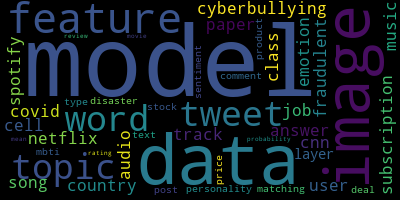

In [3]:
# Import the wordcloud library
import wordcloud

from collections import Counter
top_nwords = []
for final_doc in stemed_final_corpus:
    c_doc = Counter(final_doc)
    top_words = c_doc.most_common(5)
    print(top_words)
    t_nwords = [w[0] for w in top_words]
    top_nwords = top_nwords + t_nwords
    
long_string = " ".join(top_nwords)
wcloud = wordcloud.WordCloud()
wcloud.generate(long_string)
wcloud.to_image()

### 3. Topic Modeling

The main text analysis method that we will use is latent Dirichlet allocation (LDA). LDA is able to perform topic detection on large document sets, determining what the main 'topics' are in a large unlabeled set of texts. A 'topic' is a collection of words that tend to co-occur often. The hypothesis is that LDA might be able to clarify what the different topics in the research titles are. These topics can then be used as a starting point for further analysis.

LDA does not work directly on text data. First, it is necessary to convert the documents into a simple vector representation. This representation will then be used by LDA to determine the topics. Each entry of a 'document vector' will correspond with the number of times a word occurred in the document. In conclusion, we will convert a list of titles into a list of vectors, all with length equal to the vocabulary. For example, 'Analyzing machine learning trends with neural networks.' would be transformed into [1, 0, 1, ..., 1, 0].

We'll then plot the 10 most common words based on the outcome of this operation (the list of document vectors). As a check, these words should also occur in the word cloud.

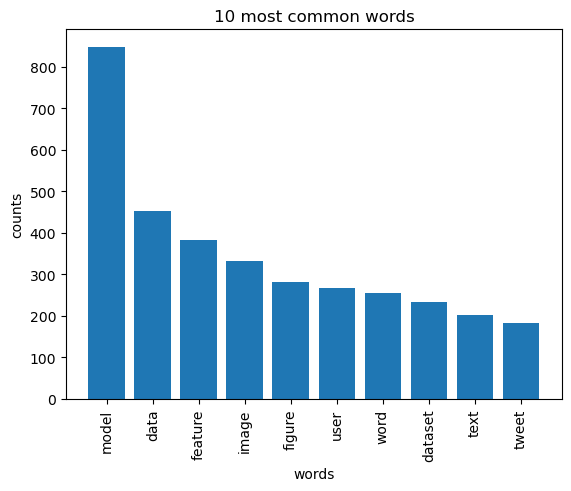

In [6]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer() 
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names_out()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 

    plt.bar(x_pos, counts,align='center')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.title('10 most common words')
    plt.show()

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer()

all_cleancorpus = [' '.join(x) for x in stemed_final_corpus]
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(all_cleancorpus)

# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [7]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below (use int values below 15)
number_topics = 5
number_words = 10

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(count_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
paper covid answer document data cord str id topic text

Topic #1:
released grown latest north amazon response analyzed distributed continuous exact

Topic #2:
model image data feature figure word text product dataset classification

Topic #3:
model sentiment data feature tweet stock prediction price comment like

Topic #4:
user model emotion song music recommendation audio dataset based track
